In [2]:
import mne
import saflow
import os
import numpy as np
import pandas as pd
import mne_bids
from scipy.signal import hilbert
from mne_bids import BIDSPath, read_raw_bids
from neurokit2.complexity import complexity_lempelziv, complexity_dimension, complexity_delay

In [3]:

def create_fnames(subject, run, bids_root=saflow.BIDS_PATH):
    morph_bidspath = BIDSPath(subject=subject,
                            task='gradCPT',
                            run=run,
                            datatype='meg',
                            processing='clean',
                            description='morphed',
                            root=bids_root + '/derivatives/morphed_sources/')
    
    preproc_bidspath = BIDSPath(subject=subject, 
                        task='gradCPT', 
                        run=run, 
                        datatype='meg', 
                        suffix='meg',
                        processing='clean',
                        root=bids_root + '/derivatives/preprocessed/')
    raw_bidspath = BIDSPath(subject=subject,
                        task='gradCPT',
                        run=run,
                        datatype='meg',
                        suffix='meg',
                        root=bids_root)
    
    return {'morph':morph_bidspath,
            'preproc':preproc_bidspath,
            'raw':raw_bidspath,
            }

filepaths = create_fnames('12', '02', bids_root='/home/hyruuk/DATA/saflow/bids')

stc = mne.read_source_estimate(filepaths['morph'])
stc = stc.crop(0,30)



In [12]:
events_full = pd.read_csv(str(filepaths['raw'].fpath).replace('_meg.ds', '_events.tsv'), sep='\t')
events_full

,onset,duration,trial_type,value,sample,trial_idx,VTC,RT,task,INOUT_50_50,INOUT_25_75,INOUT_10_90
0,0.030833,0.0,Resp,99,37,-9223372036854775808,NaN,0.000000,NaN,NaN,NaN,NaN
1,0.676667,0.0,Resp,99,812,-9223372036854775808,NaN,0.000000,NaN,NaN,NaN,NaN
2,0.841667,0.0,Freq,21,1010,0,0.804454,0.658061,correct_commission,IN,IN,IN
3,1.565833,0.0,Resp,99,1879,-9223372036854775808,NaN,0.000000,NaN,NaN,NaN,NaN
4,1.695000,0.0,Freq,21,2034,1,0.546833,0.694076,correct_commission,IN,IN,IN
...,...,...,...,...,...,...,...,...,...,...,...,...
1225,478.517500,0.0,Freq,21,574221,560,0.647346,0.861017,correct_commission,IN,IN,NaN
1226,478.555000,0.0,Resp,99,574266,-9223372036854775808,NaN,0.000000,NaN,NaN,NaN,NaN
1227,479.298333,0.0,Resp,99,575158,-9223372036854775808,NaN,0.000000,NaN,NaN,NaN,NaN
1228,479.370833,0.0,Freq,21,575245,561,0.139214,0.751059,correct_commission,IN,IN,IN


In [39]:
filepaths = create_fnames('12', '02', bids_root='/home/hyruuk/DATA/saflow/bids')
preproc = mne_bids.read_raw_bids(bids_path=filepaths['preproc'], verbose=False)
events = mne.events_from_annotations(preproc, verbose=False)

raw_bidspath = BIDSPath(subject='12', 
                        task='gradCPT', 
                        run='02', 
                        datatype='meg', 
                        suffix='meg',
                        extension='.ds',
                        root='/home/hyruuk/DATA/saflow/bids')
mne_bids.read_raw_bids(bids_path=raw_bidspath, verbose=False)
events = mne.events_from_annotations(preproc, verbose=False)


events[0].shape


(1230, 3)

In [49]:
# Load events
preproc = mne_bids.read_raw_bids(bids_path=filepaths['preproc'], verbose=False)
events, event_id = mne.events_from_annotations(preproc, verbose=False)
events_full = pd.read_csv(str(filepaths['raw'].fpath).replace('_meg.ds', '_events.tsv'), sep='\t')

# Compute time samples
tmin_samples = int(tmin * sfreq)
tmax_samples = int(tmax * sfreq)
epoch_length = tmax_samples - tmin_samples
tmin_samples = tmin_samples - int(epoch_length * (n_events_window-1))


# Segment array
segmented_array = []
events_idx = []
events_dict = []
for idx, event in enumerate(events):
    if event[2] in [1,2]:
        if event[0]+tmax_samples < data_array.shape[1]:
            if event[0]+tmin_samples > 0:
                segmented_array.append(data_array[:,event[0]+tmin_samples:event[0]+tmax_samples])
                events_idx.append(idx)

                # Fill a dict with events info
                included_events = [idx - i for i in range(n_events_window)]
                event_dict = {'event_idx':idx,
                                'VTC':events_full.loc[idx, 'VTC'],
                                'task':events_full.loc[idx, 'task'],
                                'RT':events_full.loc[idx, 'RT'],
                                'INOUT':events_full.loc[idx, 'INOUT_50_50'],
                                'INOUT_2575':events_full.loc[idx, 'INOUT_25_75'],
                                'INOUT_1090':events_full.loc[idx, 'INOUT_10_90'],
                                'included_events_idx':included_events,
                                'included_VTC':events_full.loc[included_events, 'VTC'].values,
                                'included_task':events_full.loc[included_events, 'task'].values,
                                'included_RT':events_full.loc[included_events, 'RT'].values,
                                'included_INOUT':events_full.loc[included_events, 'INOUT_50_50'].values,
                                'included_INOUT_2575':events_full.loc[included_events, 'INOUT_25_75'].values,
                                'included_INOUT_1090':events_full.loc[included_events, 'INOUT_10_90'].values,
                                }
                events_dict.append(event_dict)
segmented_array = np.array(segmented_array)
events_idx = np.array(events_idx)
print(segmented_array.shape)

(562, 8196, 1022)


-256

In [26]:
data_array = stc.data

In [4]:
def compute_hilbert_env(stc, l_freq, h_freq):
    """
    Compute the Hilbert envelope of a source estimate object, after band-pass filtering it between l_freq and h_freq.

    Parameters
    ----------
    stc : mne.SourceEstimate
        The source estimate object to compute the Hilbert envelope of.
    l_freq : float
        The lower frequency of the band-pass filter.
    h_freq : float
        The higher frequency of the band-pass filter.

    Returns
    -------
    stc_hilb : np.ndarray
        The Hilbert envelope of the source estimate object, with shape (n_vertices, n_samples).
    """
    stc_filtered = mne.filter.filter_data(np.float64(stc.data), sfreq=stc.sfreq, l_freq=l_freq, h_freq=h_freq)
    stc_hilb = np.real(hilbert(stc_filtered))**2
    return stc_hilb

def segment_sourcelevel(data_array, filepaths, sfreq=600, tmin=0.426, tmax=1.278, n_events_window=1):
    """
    Segment a source-level data array based on events from a preprocessed MEG dataset.

    Parameters
    ----------
    data_array : np.ndarray
        The source-level data array to segment.
    preproc_bidspath : mne_bids.BIDSPath
        The BIDSPath object pointing to the preprocessed MEG dataset.
    sfreq : float, optional
        The sampling frequency of the data, in Hz. Default is 600.
    tmin : float, optional
        The start time of the segment relative to the event onset, in seconds. Default is 0.426.
    tmax : float, optional
        The end time of the segment relative to the event onset, in seconds. Default is 1.278.

    Returns
    -------
    segmented_array : np.ndarray
        The segmented data array, with shape (n_events, n_channels, n_samples).
    """
    # Load events
    preproc = mne_bids.read_raw_bids(bids_path=filepaths['preproc'], verbose=False)
    events, event_id = mne.events_from_annotations(preproc, verbose=False)
    events_full = pd.read_csv(str(filepaths['raw'].fpath).replace('_meg.ds', '_events.tsv'), sep='\t')

    # Compute time samples
    tmin_samples = int(tmin * sfreq)
    tmax_samples = int(tmax * sfreq)
    epoch_length = tmax_samples - tmin_samples
    tmin_samples = tmin_samples - int(epoch_length * (n_events_window-1))


    # Segment array
    segmented_array = []
    events_idx = []
    events_dict = []
    for idx, event in enumerate(events):
        if event[2] in [1,2]:
            if event[0]+tmax_samples < data_array.shape[1]:
                if event[0]+tmin_samples > 0:
                    segmented_array.append(data_array[:,event[0]+tmin_samples:event[0]+tmax_samples])
                    events_idx.append(idx)

                    # Fill a dict with events info
                    included_events = [idx - i for i in range(n_events_window)]
                    event_dict = {'event_idx':idx,
                                  'VTC':events_full.loc[idx, 'VTC'],
                                  'task':events_full.loc[idx, 'task'],
                                  'RT':events_full.loc[idx, 'RT'],
                                  'INOUT':events_full.loc[idx, 'INOUT_50_50'],
                                  'INOUT_2575':events_full.loc[idx, 'INOUT_25_75'],
                                  'INOUT_1090':events_full.loc[idx, 'INOUT_10_90'],
                                  'included_events_idx':included_events,
                                  'included_VTC':events_full.loc[included_events, 'VTC'].values,
                                  'included_task':events_full.loc[included_events, 'task'].values,
                                  'included_RT':events_full.loc[included_events, 'RT'].values,
                                  'included_INOUT':events_full.loc[included_events, 'INOUT_50_50'].values,
                                  'included_INOUT_2575':events_full.loc[included_events, 'INOUT_25_75'].values,
                                  'included_INOUT_1090':events_full.loc[included_events, 'INOUT_10_90'].values,
                                  }
                    events_dict.append(event_dict)
    segmented_array = np.array(segmented_array)
    events_idx = np.array(events_idx)
    return segmented_array, events_idx, events_dict

def time_average(segmented_array):
    """
    Average the time dimension of a segmented data array.

    Parameters
    ----------
    segmented_array : np.ndarray
        The segmented data array, with shape (n_events, n_channels, n_samples).

    Returns
    -------
    time_avg_array : np.ndarray
        The time-averaged data array, with shape (n_events, n_channels).
    """
    time_avg_array = []
    for array in segmented_array:
        time_avg_array.append(np.mean(array, axis=1))
    time_avg_array = np.array(time_avg_array)
    return time_avg_array

def compute_PSD(stc, filepaths):
    """
    Compute the power spectral density (PSD) of a source estimate object across different frequency bands.

    Parameters
    ----------
    stc : mne.SourceEstimate
        The source estimate object to compute the PSD of.

    Returns
    -------
    psd_array : np.ndarray
        The PSD of the source estimate object, with shape (n_freq_bands, n_events, n_channels).
    """
    psd_array = []
    for idx, freq in enumerate(saflow.FREQS_NAMES):
        stc_env = compute_hilbert_env(stc, saflow.FREQS[idx][0], saflow.FREQS[idx][1])
        segmented_array, events_idx = segment_sourcelevel(stc_env, filepaths, sfreq=stc.sfreq)
        time_avg_array = time_average(segmented_array)
        psd_array.append(time_avg_array)
    psd_array = np.array(psd_array)
    return psd_array, events_idx

In [14]:
psd_array = compute_PSD(stc, preproc_bidspath)

NameError: name 'preproc_bidspath' is not defined

In [16]:
def compute_LZC_on_epochs(stc, filepaths):
    """
    Compute the Lempel-Ziv complexity (LZC) of the source estimate object across different epochs and channels.

    Parameters
    ----------
    stc : mne.SourceEstimate
        The source estimate object to compute the LZC of.
    filepaths : dict
        A dictionary containing the filepaths of the preprocessed MEG dataset.

    Returns
    -------
    lzc_array : np.ndarray
        The LZC of the source estimate object, with shape (n_epochs, n_channels, 2), where the last dimension contains the LZC and the permuted LZC.
    """
    # Segment array
    segmented_array, events_idx, events_dicts = segment_sourcelevel(stc.data, filepaths, sfreq=stc.sfreq)
    lzc_array = []
    for epoch in segmented_array:
        epoch_array = []
        for channel in epoch:
            print(f'Epoch {epoch} - Channel {channel}')
            # Compute LZC and permuted LZC
            plzc = complexity_lempelziv(channel, permutation=True, dimension=7, delay=2)[0]
            lzc = complexity_lempelziv(channel, permutation=False)[0]
            epoch_array.append([lzc, plzc])
        epoch_array = np.array(epoch_array)
        lzc_array.append(epoch_array)
    lzc_array = np.array(lzc_array)
    return lzc_array


filepaths = create_fnames('12', '02', bids_root='/home/hyruuk/DATA/saflow/bids')

lzc_array = compute_LZC_on_epochs(stc, filepaths)


KeyboardInterrupt: 

In [ ]:
lzc_array.shape


(10, 20484, 2)

(0,)

## Epoch-level FOOOF

In [9]:
segmented_array, events_idx, events_dicts = segment_sourcelevel(stc.data, filepaths, sfreq=stc.sfreq, n_events_window=8)

In [10]:
segmented_array.shape

(55, 8196, 8176)

In [49]:
power_spectrum = abs(np.fft.fft(channel))**2
freqs = np.fft.fftfreq(channel.size, 1/stc.sfreq)
fooof_bounds = [5,40]
mask = np.logical_and(freqs >= fooof_bounds[0], freqs <= fooof_bounds[1])


from fooof import FOOOF
fm = FOOOF(max_n_peaks=3)
fm.fit(freqs[mask], power_spectrum[mask])
fm.get_params('aperiodic_params')


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.17
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



array([-17.37135254,   0.08121108])

## FOOOF 3d ?

In [11]:
fooof_array = []
for epoch in segmented_array:
    chan_array = []
    for channel in epoch[:20,:]:
        power_spectrum = abs(np.fft.fft(channel))**2
        freqs = np.fft.fftfreq(channel.size, 1/stc.sfreq)
        fooof_bounds = [5,40]
        mask = np.logical_and(freqs >= fooof_bounds[0], freqs <= fooof_bounds[1])
        freqs = freqs[mask]
        chan_array.append(power_spectrum[mask])
    chan_array = np.array(chan_array)
    fooof_array.append(chan_array)
fooof_array = np.array(fooof_array)



In [64]:
np.fft.fftfreq(channel.size, 1/stc.sfreq)

array([   0.        ,    1.1741683 ,    2.34833659,    3.52250489,
          4.69667319,    5.87084149,    7.04500978,    8.21917808,
          9.39334638,   10.56751468,   11.74168297,   12.91585127,
         14.09001957,   15.26418787,   16.43835616,   17.61252446,
         18.78669276,   19.96086106,   21.13502935,   22.30919765,
         23.48336595,   24.65753425,   25.83170254,   27.00587084,
         28.18003914,   29.35420744,   30.52837573,   31.70254403,
         32.87671233,   34.05088063,   35.22504892,   36.39921722,
         37.57338552,   38.74755382,   39.92172211,   41.09589041,
         42.27005871,   43.44422701,   44.6183953 ,   45.7925636 ,
         46.9667319 ,   48.1409002 ,   49.31506849,   50.48923679,
         51.66340509,   52.83757339,   54.01174168,   55.18590998,
         56.36007828,   57.53424658,   58.70841487,   59.88258317,
         61.05675147,   62.23091977,   63.40508806,   64.57925636,
         65.75342466,   66.92759295,   68.10176125,   69.27592

In [12]:
from fooof import FOOOFGroup
from fooof.objs import fit_fooof_3d, combine_fooofs


fg = FOOOFGroup(peak_width_limits=[2, 6], min_peak_height=0.1)
fgs = fit_fooof_3d(fg, freqs, fooof_array)

/tmp/ipykernel_60399/1143179782.py:1: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:49: RuntimeWarning: invalid value encountered in scalar divide
  t2 = c / q
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_l

Running FOOOFGroup across 1100 power spectra.


/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:49: RuntimeWarning: invalid value encountered in scalar divide
  t2 = c / q
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/home/hyruuk/mambaforge/envs/saflow/lib/python3.11/site-packages/scipy/optimize

In [81]:
segmented_array.shape

(10, 20484, 511)

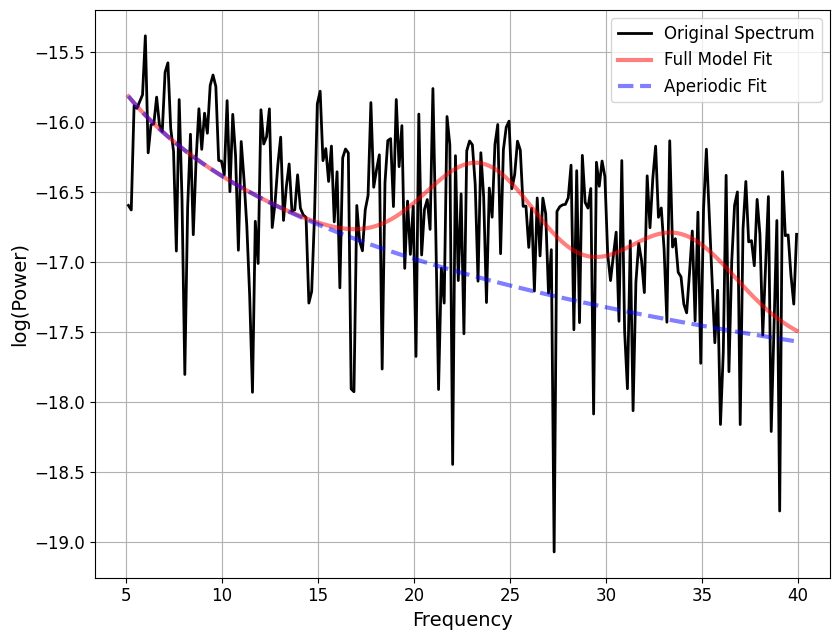

In [13]:
import fooof
fm = fgs[3].get_fooof(1)
fm.plot()

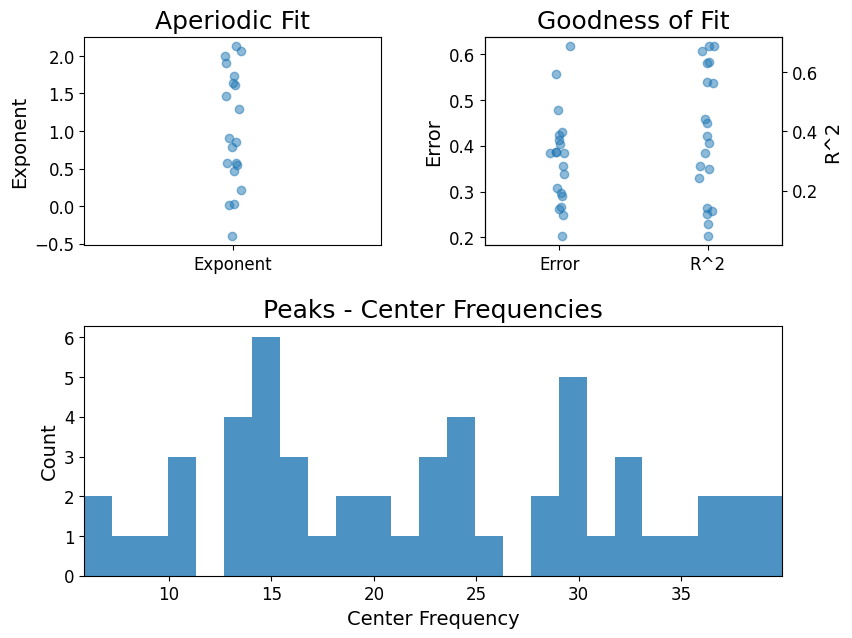

In [80]:
fgs[0].plot()

## Time-resolved FOOOF

In [3]:
from math import floor
from statistics import median
from itertools import compress
import numpy as np
import os
import csv
import matplotlib
import fooof
from fooof.data import FOOOFResults
from fooof.sim.gen import gen_periodic
from fooof.sim.gen import gen_aperiodic
from fooof.objs.utils import combine_fooofs
from copy import deepcopy

def SPRiNT_stft_py(F, opt):
    ''' SPRiNT_stft_py: Compute a locally averaged short-time Fourier transform
    (for use in SPRiNT)

    Inputs
    F - Time series (nxm numpy array),
    where n is number of channels, m is number of samples
    opt - Model settings/hyperparameters (dict)

    Segments of this function were adapted from the Brainstorm software package:
    https://neuroimage.usc.edu/brainstorm
    Tadel et al. (2011)

    Author: Luc Wilson (2023)
    '''
    # Get sampling frequency
    n_chan = F.shape
    # print(n_chan)
    if not len(n_chan) > 1:
        n_sample = n_chan[0]
    else:
        n_sample = n_chan[1]

    sfreq = opt['sfreq']
    avgWin = opt['WinAverage']

    # Initialize returned values
    ind_good = 1  # index for kept data

    # WINDOWING
    Lwin = round(opt['WinLength'] * opt['sfreq'])  # n data points per window
    Loverlap = round(Lwin * opt["WinOverlap"] / 100)  # n data points in overlap

    # If window is too small
    Messages = []
    if Lwin < 50:
        print("Time window too small, please increase and run process again.")
        return
    # If window is bigger than the data
    elif Lwin > n_sample:
        Lwin = len(F[0])
        Lwin = Lwin - (Lwin % 2)  # Make sure the number of samples is even
        Loverlap = 0
        Nwin = 1
        print("Time window too large, using entire recording for spectrum.")
    # Else: there is at least one full time window
    else:
        Lwin = Lwin - (Lwin % 2)  # Make sure the number of samples is even
        Nwin = (n_sample - Loverlap) // (Lwin - Loverlap)

    # Positive frequency bins spanned by FFT
    FreqVector = sfreq / 2 * np.linspace(0, 1, round(Lwin / 2 + 1))
    # Determine hamming window shape/power
    Win = np.hanning(Lwin)
    WinNoisePowerGain = sum(Win**2)
    # Initialize STFT, time matrices
    ts = np.full((Nwin-(avgWin-1)),np.nan)
    if len(n_chan) > 1:
        TF = np.full((len(F), Nwin - (avgWin - 1), len(FreqVector)), np.nan)
        TFtmp = np.full((len(F), avgWin, len(FreqVector)), np.nan)
    else:
        TF = np.full((1, Nwin - (avgWin - 1), len(FreqVector)), np.nan)
        TFtmp = np.full((1, avgWin, len(FreqVector)), np.nan)
    # Calculate FFT for each window
    TFfull = np.zeros((len(F), Nwin, len(FreqVector)))
    for iWin in range(Nwin):
        # print(iWin)
        # Build indices
        iTimes = list(range((iWin)*(Lwin-Loverlap),Lwin+(iWin)*(Lwin-Loverlap)))
        center_time = floor(median(np.add(np.array(iTimes),1))-\
            (avgWin-1)/2*(Lwin-Loverlap))/200
        if len(n_chan) > 1:
            Fwin = F[:, iTimes]
            Fwin = Fwin- Fwin.mean(axis=1, keepdims=True)
        else:
            # print(iTimes)
            Fwin = F[iTimes]
            # print(Fwin)
            Fwin = Fwin - Fwin.mean()
        # Apply a Hann window to signal
        Fw = np.multiply(Fwin,Win)
        # Compute FFT
        Ffft = np.fft.fft(Fw, Lwin)
        if len(n_chan) > 1:
            TFwin = Ffft[:, :Lwin//2+1] * \
                np.sqrt(2 / (sfreq * WinNoisePowerGain))
            TFwin[:, [0, -1]] = TFwin[:, [0, -1]] / np.sqrt(2)
            # print(TFwin)
            TFwin = np.abs(TFwin)**2
            TFfull[:,iWin,:] = TFwin
            TFtmp[:, iWin % avgWin, :] = TFwin
            # print(iWin%avgWin)
        else:
            TFwin = Ffft[:Lwin//2+1] * np.sqrt(2 / (sfreq * WinNoisePowerGain))
            TFwin[[0, -1]] = TFwin[[0, -1]] / np.sqrt(2)
            # print(TFwin)
            TFwin = np.abs(TFwin)**2
            TFfull[:,iWin,:] = TFwin
            TFtmp[:, iWin % avgWin, :] = TFwin
        if np.isnan(TFtmp[-1, -1, -1]):
            pass
            # continue  # Do not record anything until transient is gone
        else:
            # Save STFTs for window
            TF[:, iWin - (avgWin - 1), :] = np.mean(TFtmp, axis=1)
            ts[iWin - (avgWin - 1)] = center_time
            # print(center_time)

    output = {
        "TF": TF,
        "freqs": FreqVector,
        "ts": ts,
        "options": opt
    }

    return output

opt = {
    "sfreq": stc.sfreq,  # Input sampling rate
    "WinLength": 0.852,  # STFT window length
    "WinOverlap": 90,  # Overlap between sliding windows (in %)
    "WinAverage": 5, # Number of overlapping windows being averaged
    "rmoutliers": 1, # Apply peak post-processing
    "maxTime": 6, # Maximum distance of nearby peaks in time (in n windows)
    "maxFreq": 2.5, # Maximum distance of nearby peaks in frequency (in Hz)
    "minNear": 3, # Minimum number of similar peaks nearby (using above bounds)
    }

TF = SPRiNT_stft_py(stc.data, opt)
TF['TF'].shape


/tmp/ipykernel_127581/127511013.py:8: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  import fooof


(20484, 106, 256)

NameError: name 'events' is not defined

In [ ]:
# Print number of bad epochs
import saflow
import pickle
for subj in saflow.SUBJ_LIST:
    for run in saflow.BLOCS_LIST:
        run = '0' + run
        filepaths = create_fnames(subj, run)
        with open(str(filepaths['ARlog'].fpath)+'.pkl', 'rb') as f:
            ARlog = pickle.load(f)
        print(f'sub-{subj}_run-{run}')
        print(np.sum(ARlog.bad_epochs))